# SimMod 2. Audio features
## 1. Author Documentation

- Alexander Haberl (11806899)
- Alina Godun (01569197)

### Timesheets
#### Alexander Haberl

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 15:00-16:00 | Preparation for registration assesment test |
| 2023/10/10 | 18:45-19:10 | Registration assesment test |
| 2023/10/12 | 10:00-11:00 | Pre-lecture meeting |
| 2023/11/02 | 18:00-22:00 | Watching lectures 6 and 7 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/09 | 19:00-22:00 | Watching lectures 8 and 9 |
| 2023/11/19 | 16:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 00:00-02:30 | Writing abstracts for SimMod 1 and 2 |
| 2024/01/10 | 18:00-22:00 | SimMod 2 Research for i Vectors |
| 2024/01/11 | 18:00-22:00 | SimMod 2 Research and implementation for i Vectors |
| 2024/01/13 | 10:30-22:00 | SimMod 2 First audio features for Pigs and Cook |
| 2024/01/14 | 10:30-22:00 | SimMod 2 Video features for Pigs and Cook |
| 2024/01/14 | 23:00-01:00 | SimMod 2 Hand In Notebook |

#### Alina Godun

| Date | Time | Task |
| -------- | -------- | -------- |
| 2023/10/10 | 17:30-18:30 | Preparation for registration assesment test |
| 2023/10/10 | 19:10-19:30 | Registration assesment test |
| 2023/10/28 | 20:00-00:00 | Watching lectures 4 to 6 |
| 2023/11/08 | 10:00-12:00 | Live lecture on essentials |
| 2023/11/18 | 16:00-20:00 | Watching lectures 7 and 8 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 11:00-12:30 | Watching lecture 9 |
| 2023/11/19 | 19:00-00:00 | Writing abstracts for SimMod 1 and 2 |
| 2023/11/20 | 19:00-02:00 | Writing abstracts for SimMod 1 and 2 |
| 2024/01/13 | 10:30-22:00 | SimMod 2 Video features for Pigs and Cook |
| 2024/01/14 | 10:30-22:00 | SimMod 2 Audio features for Pigs and Cook |
| 2024/01/14 | 23:00-01:00 | SimMod 2 Hand In Notebook |

## 2. Environment
To install all required libraries, create a conda environment from the conda_env.yml file:

```conda env create -f conda_env.yml```

Then activate the environment:

```conda activate SimilarityModeling```

Start jupyterlab (optional):

```jupyter lab```

## 3. Train Test Splitting

We can't randomly sample frames, because two neighboring frames are very, very similar and would lead to data leakage.
Therefore we split each episode into 2 parts of approximately equal length. Cuts were made when a new scene started, ensuring that no scene is present in both parts. This results in 6 episode partitions in total. 

We perfom nested cross-validation. 5/6 splits are used for the inner CV-loop (4/6 are used for training and 1/6 is used for validation). The outer CV-loop uses 1/6 as a testset.

The inner CV-loop is for hyperparameter tuning. All parameter combinations of the classifiers are evaluated on on each of the inner CV-folds. The hyperparameter-combination that performs the best on average is chosen for each classifier. Then each classifier is retrained on the whole 5/6 of the train-validation data with its best hyperparameters and then evaluated on the test-set. The final result is the average for each classifier over all test-folds. The best model is the one that performs the best on the outer-loop on average. 

Basically the inner-loop is for automatic hyperparameter tuning (and we don't care about the actual values of the hyperparameters), while the outer loop is for model comparison.

By doing nested cross-validation, we don't have to ensure that the test-set is representative because all frames are used for testing. If we only did holdout we would have a test-set with stronger bias, which might favor one classifier.

Since Swedish Chef (Cook) has only a very minor amount of appearances in the dataset, during CV we skip folds, where Chef is not present in the train data. There are some folds, where Swedish Chef is not present in the outer test fold, but we still run the inner CV experiments since Swedish Chef will have an appearance in the validation fold of the inner CV, so the classifier performace is still being evaluated.

## 4. Feature extraction
We extract all audio features using librosa library. We use frames of length 0.1s to extract features, so we also consider audio "before" and "after" the frame, not only during the frame. Since we cut episodes into parts between the scenes, we don't have to worry about audio features leakage due to audio being present in test and train datasets.

After feature extraction we obtain a very large amount of audio features (101). Since large amount of features can result in curse of dimensionality, especially because we have a very small number of positive samples. That's why we reduce the number of dimensions with PCA during classification step. We don't set a fix amount of PCA components, instead we set a parameter to keep the amount of components which explain minimum 85% of variance in data.

### 4.1 Load Data

In [1]:
%load_ext autoreload
%autoreload 2

import re
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture

from utils import io, train, eval
from utils import feature_engineering as fe

import librosa
import numpy as np

In [2]:

videos_folder = "../data/videos"
gt_folder = "../data/gt_annotations"
temp_folder = "../data/tmp/"

episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

In [3]:
extract_mfcc = False
extract_hmm_mfcc = False
extract_chroma = False
extract_contrast = False

# set this param to True if you want to train hidden markov models from scratch
load_recordings = False

### 4.2 MFCC
Mel-Frequency Cepstral Coefficients (MFCCs) describe the overall shape of the spectral envelope and are often used for speech and speaker recognition. It is said that MFCCs represent "timbre". The frequency bands in MFCCs are spaced on the mel scale, which approximates the sound in terms of human hearing.

We compute not only the normal MFCCs, but also their derivatives:
- Locally normalized MFCCs (by cepstral mean and variance), which tries to minimize the signal distortion by noise contamination
- Delta (differential) and delta-delta (acceleration) MFCCs, which represent the dynamics of the power spectrum and trajectories of MFCCs over time

In [4]:
if extract_mfcc:
    feats = fe.get_mfcc(episode_names, video_paths, gt_df)

    pickle.dump(feats, open("../data/features/mfcc_feats.pkl", "wb"))

### 4.3 MFCC with HMM
Since the audio features performed quite bad when directly applied to a classifier, we tried to mimic a more common approach in speaker recognition by splitting the audio data into sequences of utterances. MFCCs are computed for these sequences. The MFCCs are then fed to a HMM, which should describe the behaviour of the speech segments. In the ideal case the HMM would learn the unique voice characterstics of each person. We create two HMM for each target (e.g. 'Chef speaking'/'Chef not speaking'). We get the scores of the utterances on each HMMs. We use these scores and a boolean flag that indicates which HMM had the highest score as the features for the main classifier. During inference we split the test-set into 1 second long speech-segments and feed each of them into the HMM, therefore getting the scores as well.

In [5]:
if extract_hmm_mfcc:
    feats = fe.get_sequences_for_hmm_mfcc(episode_names, video_paths, gt_df)

    pickle.dump(feats, open("../data/features/hmm_mfcc_sequences_feats.pkl", "wb"))

### 4.4 Chroma

Our next feature, chroma, represents tonal content of an audio signal in a condensed form. They capture harmonic and melodic characteristics of music, and are usually used for pitch recognition in music analysis.
They are not very useful for voice recognition, but our consideration was that the presence/absence of a specific music themes could also be helpful for a classifier.

In [6]:
if extract_chroma:
    feats = fe.get_chroma(episode_names, video_paths, gt_df)

    pickle.dump(feats, open("../data/features/chroma_feats.pkl", "wb"))

### 4.5 Spectral Contrast
Spectral contrast is estimated by comparing the peak energy (mean energy in the top quantile) to the valley energy (mean energy in the bottom quantile). This feature represents clarity of the signal: noisy broad-band audio would have low contrast values, clear narrow-band audio signals would correspond to high contrast values.

In [7]:
if extract_contrast:
    feats = fe.get_spectral_contrast(episode_names, video_paths, gt_df)

    pickle.dump(feats, open("../data/features/contrast_feats.pkl", "wb"))

### 4.6 Failed approaches
We also tried to create i-vectors as they are a very efficient representation of audio data. Unfortunately there exists no easy-to-use library for python. Most of them require a very specific folder structure and many lines of code to get them running. Therefore we tried to implement the i-vectors our selves, but the papers were not written in a straight-forward way, because they are very heavy on math. We found some python scripts that wrote an i-vector extraction from scratch, but we had issues getting it to run. In the end we decided to drop this approach, because the deadline was approaching.

## 5. Classification

### 5.1 Load features

The (pre-)computed features are loaded from the ```data/features``` directory.

In [8]:
final_df = gt_df.copy()

In [9]:
mfcc_feat_dict = pickle.load(open("../data/features/mfcc_feats.pkl", "rb"))

for ep in episode_names:
    for feat_name, feats in mfcc_feat_dict[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feats

In [10]:
chroma_feat_dict = pickle.load(open("../data/features/chroma_feats.pkl", "rb"))

for ep in episode_names:
    for feat_name, feat in chroma_feat_dict[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat

In [11]:
contrast_feat_dict = pickle.load(open("../data/features/contrast_feats.pkl", "rb"))

for ep in episode_names:
    for feat_name, feat in contrast_feat_dict[ep].items():
        final_df.loc[final_df['episode'] == ep, feat_name] = feat.astype(np.float32)

In [12]:
sequences = pickle.load(open("../data/features/hmm_mfcc_sequences_feats.pkl", "rb"))
recordings = {}
if load_recordings:
    for ep in episode_names:
        rec, sr = librosa.load(video_paths[ep], sr=None)
        recordings[ep] = (rec, sr)

### 5.2 Run experiments

As was mentioned earlier in 4. Feature extraction, we use PCA to reduce number of features to reduce dimensionality of input features.

Since we only obtain the train-validation-test splits during training, and we have to train the hidden markov models on the train splits to avoid data leakage, we compute the HMM MFCCs during training. It takes quite some time to compute the features (30 minutes on our machines), so as in case with other features, we already precomputed the features. If you want to train hidden markov models and generate the scores from scratch, set ```preload_hmm``` parameter to ```False``` and ```load_recordings``` (in feature extraction part) to ```True```.

On our machines, the training takes approx. 7 mins for each class (with precomputed HMM), or approx. 14 minutes in total. If you want to retrain a classifier and generate new evaluation data, set ```train_models``` param to ```True``` (make sure that ```save_results``` is also set to ```True```, so that evaluation data is saved). Important! Each classification target (Pigs/Swedish chef) has it's own parameters, if you want to retrain both, change parameters in both places.

For our experiments, we decided to use:
- Linear SVM (according to sklearn, linear svm is better suited for datasets with >10.000 training samples than normal svm)
- Gaussian Naive Bayes (according to sklearn, suited for binary classification problems on non-categorical data).
- Gaussian Mixtures
classifiers to cover wide range of different types of classifiers.  

#### 5.2.1 Pigs

In [13]:
train_models = False
save_results = True
preload_hmm = True
feat_type = 'audio'
target_col = 'Audio_Pigs'
split_col = 'episode_split'
pca_n_components = 3
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'mfcc' in c
              or 'chroma' in c
              or 'contrast' in c
             ]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training (before PCA, without HMM MFCCs): \n- {train_cols_str}")

Columns used for training (before PCA, without HMM MFCCs): 
- mfcc_0
- mfcc_1
- mfcc_2
- mfcc_3
- mfcc_4
- mfcc_5
- mfcc_6
- mfcc_7
- mfcc_8
- mfcc_9
- mfcc_10
- mfcc_11
- mfcc_12
- mfcc_13
- mfcc_14
- mfcc_15
- mfcc_16
- mfcc_17
- mfcc_18
- mfcc_19
- delta_mfccs_0
- delta_mfccs_1
- delta_mfccs_2
- delta_mfccs_3
- delta_mfccs_4
- delta_mfccs_5
- delta_mfccs_6
- delta_mfccs_7
- delta_mfccs_8
- delta_mfccs_9
- delta_mfccs_10
- delta_mfccs_11
- delta_mfccs_12
- delta_mfccs_13
- delta_mfccs_14
- delta_mfccs_15
- delta_mfccs_16
- delta_mfccs_17
- delta_mfccs_18
- delta_mfccs_19
- delta_2_mfccs_0
- delta_2_mfccs_1
- delta_2_mfccs_2
- delta_2_mfccs_3
- delta_2_mfccs_4
- delta_2_mfccs_5
- delta_2_mfccs_6
- delta_2_mfccs_7
- delta_2_mfccs_8
- delta_2_mfccs_9
- delta_2_mfccs_10
- delta_2_mfccs_11
- delta_2_mfccs_12
- delta_2_mfccs_13
- delta_2_mfccs_14
- delta_2_mfccs_15
- delta_2_mfccs_16
- delta_2_mfccs_17
- delta_2_mfccs_18
- delta_2_mfccs_19
- normalized_mfcc_0
- normalized_mfcc_1
- normaliz

In [14]:
clf_config = [
    {
        'model_name': 'linSVC',	
        'model': LinearSVC(),
        'param_grid': {
            'clf__dual': ['auto'],
            'clf__loss': ['hinge', 'squared_hinge'],
            'clf__class_weight': ['balanced']
        },
    },
    {
        'model_name': 'NaiveBayes',
        'model': GaussianNB(),
        'param_grid': {
        },
    },
    {
        'model_name': 'GM',
        'model': GaussianMixture(),
        'param_grid': {
            'clf__n_components': [2],
            'clf__init_params': ['kmeans', 'random'],
            'clf__max_iter': [100, 200]
        },
    }
]

In [15]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv_with_hmm(final_df, sequences, recordings, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type, load_hmm=preload_hmm)

#### 5.2.2 Cook

In [16]:
train_models = False
save_results = True
preload_hmm = True
feat_type = 'audio'
target_col = 'Audio_Cook'
split_col = 'episode_split'
split_ids = final_df[split_col].unique()
split_ids.sort()

train_cols = [c for c in final_df.columns 
              if 'mfcc' in c
              or 'chroma' in c
              or 'contrast' in c
             ]
train_cfg = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_cols})

train_cols_str = '\n- '.join(train_cols)
print(f"Columns used for training (before PCA, without HMM MFCCs): \n- {train_cols_str}")

Columns used for training (before PCA, without HMM MFCCs): 
- mfcc_0
- mfcc_1
- mfcc_2
- mfcc_3
- mfcc_4
- mfcc_5
- mfcc_6
- mfcc_7
- mfcc_8
- mfcc_9
- mfcc_10
- mfcc_11
- mfcc_12
- mfcc_13
- mfcc_14
- mfcc_15
- mfcc_16
- mfcc_17
- mfcc_18
- mfcc_19
- delta_mfccs_0
- delta_mfccs_1
- delta_mfccs_2
- delta_mfccs_3
- delta_mfccs_4
- delta_mfccs_5
- delta_mfccs_6
- delta_mfccs_7
- delta_mfccs_8
- delta_mfccs_9
- delta_mfccs_10
- delta_mfccs_11
- delta_mfccs_12
- delta_mfccs_13
- delta_mfccs_14
- delta_mfccs_15
- delta_mfccs_16
- delta_mfccs_17
- delta_mfccs_18
- delta_mfccs_19
- delta_2_mfccs_0
- delta_2_mfccs_1
- delta_2_mfccs_2
- delta_2_mfccs_3
- delta_2_mfccs_4
- delta_2_mfccs_5
- delta_2_mfccs_6
- delta_2_mfccs_7
- delta_2_mfccs_8
- delta_2_mfccs_9
- delta_2_mfccs_10
- delta_2_mfccs_11
- delta_2_mfccs_12
- delta_2_mfccs_13
- delta_2_mfccs_14
- delta_2_mfccs_15
- delta_2_mfccs_16
- delta_2_mfccs_17
- delta_2_mfccs_18
- delta_2_mfccs_19
- normalized_mfcc_0
- normalized_mfcc_1
- normaliz

In [17]:
clf_config = [
    {
        'model_name': 'linSVC',	
        'model': LinearSVC(),
        'param_grid': {
            'clf__dual': ['auto'],
            'clf__loss': ['hinge', 'squared_hinge'],
            'clf__class_weight': ['balanced']
        },
    },
    {
        'model_name': 'NaiveBayes',
        'model': GaussianNB(),
        'param_grid': {
        },
    },
    {
        'model_name': 'GM',
        'model': GaussianMixture(),
        'param_grid': {
            'clf__n_components': [2],
            'clf__init_params': ['kmeans', 'random'],
            'clf__max_iter': [100, 200]
        },
    }
]

In [18]:
if train_models:
    eval_df, clf_dict_outer, tprs_dict = train.train_full_cv_with_hmm(final_df, sequences, recordings, clf_config, train_cfg, split_ids, train_cols, target_col, split_col, save_results, feat_type, load_hmm=preload_hmm)

## 6. Results & Discussion

#### 6.1 Pigs

In [19]:
target_col = 'Audio_Pigs'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))

In [20]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

The following curves provide infomation about precision, recall, TPR and FPR for all experiment runs and parameter combinations, both from inner and outer CV loops.

As we can see, all classifiers have a high recall, but quite low precision, probably due to small amount of samples for the positive class, which make it's identification quite complicated. We can also see from the ROC curve, that classifiers managed to achieve high TPR, but FPR is also quite high.

It seems that linear SVM performs slightly better than other models, but all in all there is little difference across models.

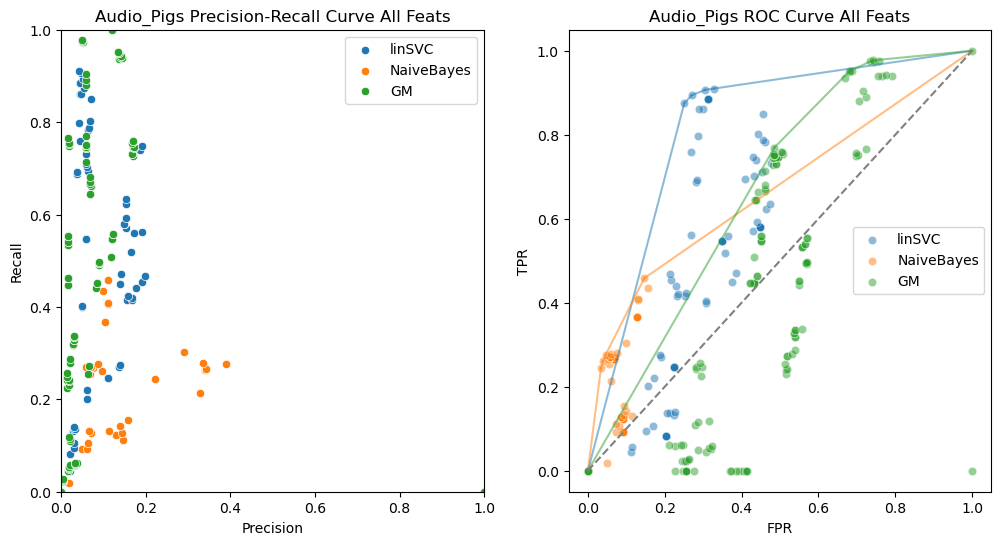

In [43]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0], plot_curve=False, sim_mod='SimMod2')
eval.plot_roc_curve(fpr_dict, tpr_dict, model_names=clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1], sim_mod='SimMod2')

The following curves provide the information about TPR and FPR at different classification thresholds for the best hyperparameter combinations of each model. It also shows that the classification is very challenging, probably because of not having enough positive samples and extracted features not being good enough. We can also see that the result is very test-train split dependent, which might indicate that we don't have enough positive samples.

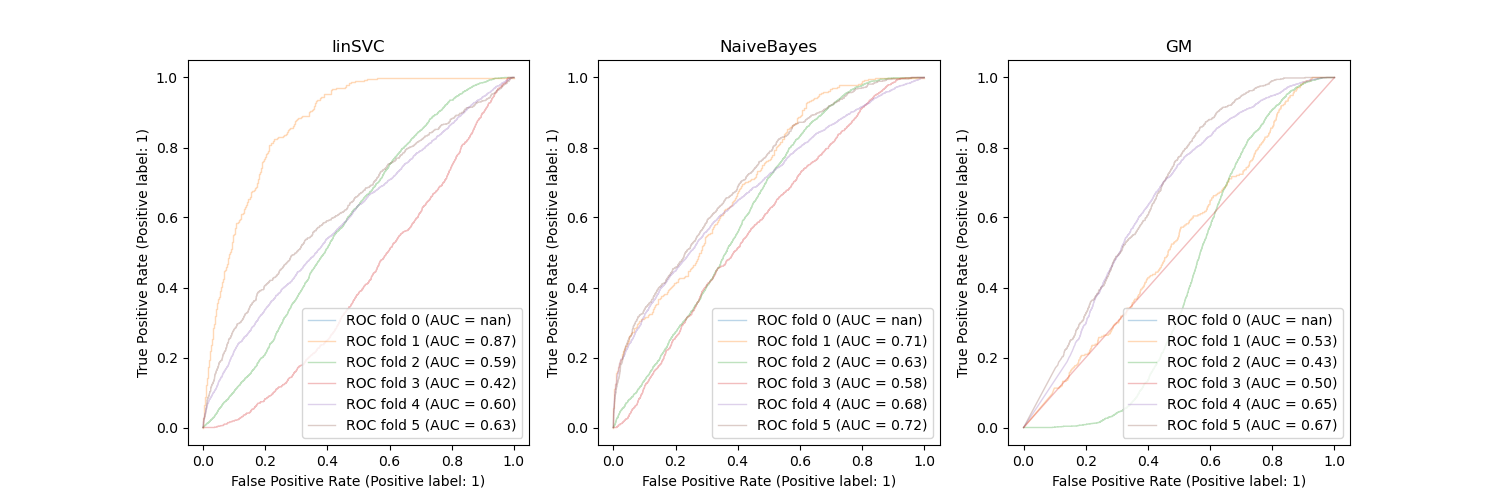

In [44]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_{feat_type}_precision_recall.png"
display(Image(filename=filename))

#### 6.2 Cook

In [22]:
target_col = 'Audio_Cook'
eval_df = pd.read_csv(f"../data/eval/DT_{target_col}_{feat_type}_eval_df.csv")
clf_dict_outer = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_clf_info.pkl", "rb"))
tprs_dict = pickle.load(open(f"../data/models/DT_{target_col}_{feat_type}_tpr_info.pkl", "rb"))

In [23]:
precision_dict, recall_dict, f1_dict, fpr_dict, tpr_dict = eval.get_eval_info(eval_df, clf_dict_outer)

As we can see, the performance for Swedish chef is even worse than for Pigs. The result provided by the classifier is not entirely random, but somewhat close to it. Linear SVM seems to handle the data imbalance slightly better than other models.

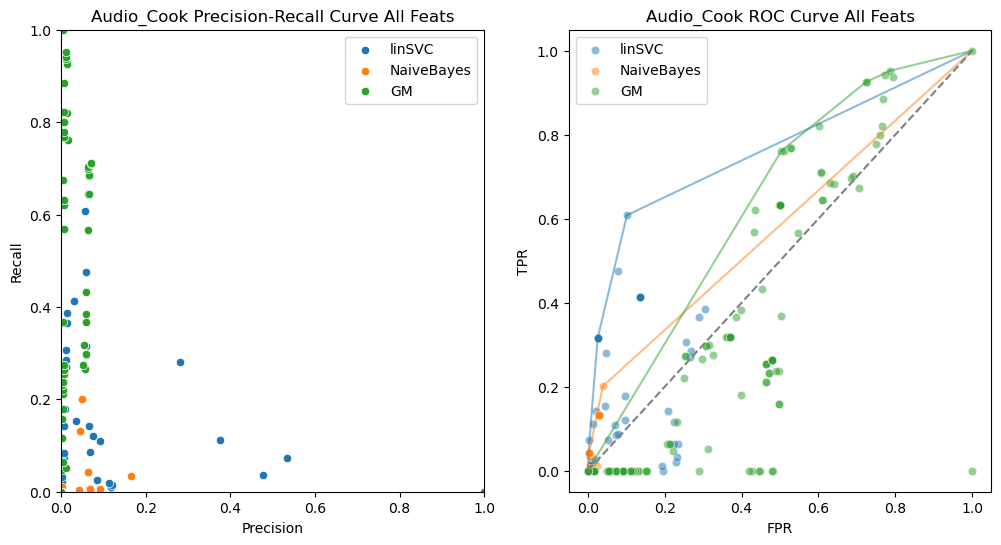

In [47]:
_, axes = plt.subplots(1, 2, figsize=(12, 6))
eval.plot_precision_recall_curve(precision_dict, recall_dict, clf_dict_outer.keys(), title=f'{target_col} Precision-Recall Curve All Feats', ax=axes[0], plot_curve=False, sim_mod='SimMod2')
eval.plot_roc_curve(fpr_dict, tpr_dict, clf_dict_outer.keys(), title=f'{target_col} ROC Curve All Feats', ax=axes[1], plot_curve=True, sim_mod='SimMod2')


The following curves also demonstrate that the performance of the classifier is extremely fold dependent (which makes sense, since we only have 2 scenes with Swedish chef in the dataset). The performance is not very good and pretty much close to random.

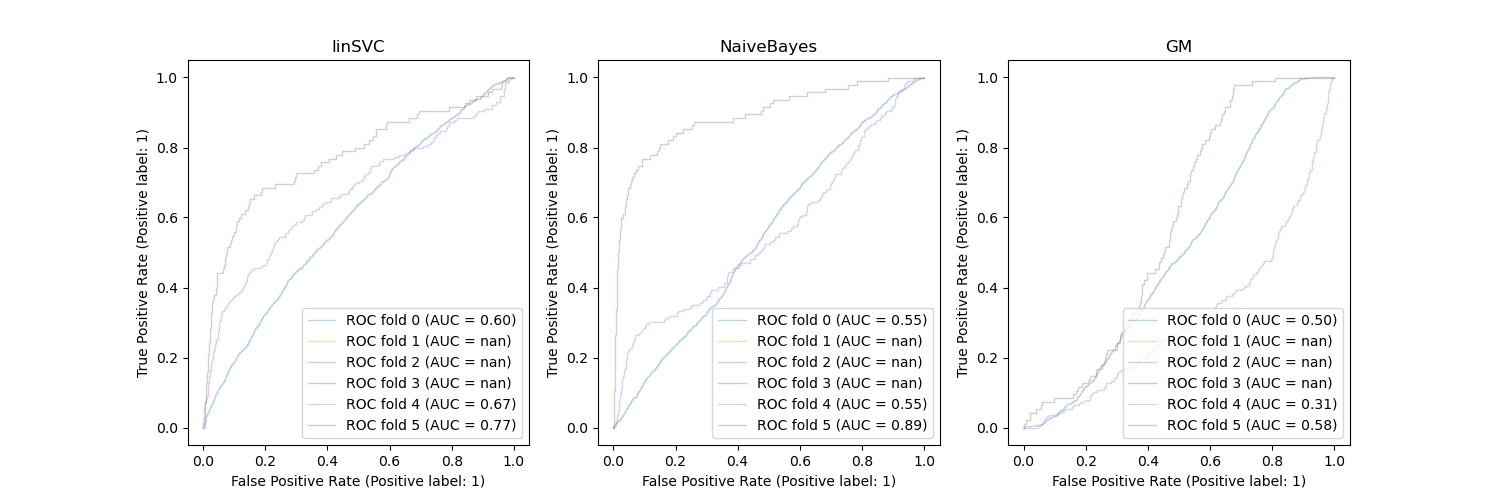

In [48]:
from IPython.display import Image, display
filename = f"../data/eval/DT_{target_col}_{feat_type}_precision_recall.png"
display(Image(filename=filename))

## 7. Conclusion
The classification of Pigs and Swedish chef was very challenging. The first reason is that the dataset is heavily imbalanced, there is a very little number of positive samples in comparison to the negative samples. Especially in case with Swedish chef: he only has 2 scenes, and if one wants to avoid data leakage, one cannot split these scenes into multiple parts, since frames look very similar to each other and we would basically test on the same data we've used for training. This means that we can only train classifier on one scene, which is not enough to create a good classifier.

Another reason why this assignment was challenging is that it was hard to find the ready-made implementations which would be easy to run of the features introduces in SimMod 2 (e.g., i-vectors). Hence we were limited in our choice of features for classification.